# 0 Required imports, hyperparameters and general functions

## 0.1 Required imports

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage.feature import hog
from scipy.ndimage.measurements import label
import glob
import time

## 0.2 Hyperparameters

In [2]:
# HYPERPARAMETERS

# 1.1 Initialize images and labels:
test_size=0.2

# 1.2 Extract image features
color_space = "YCrCb"
orient=6
pix_per_cell=8
cell_per_block=2
hog_channel = "ALL"
classifier_shape = (24,24) # Defines the image shape required for the classifier

# 2.3 Get image heatmap and return window
# Pixel size of input images
input_image_shape_x = 1280
input_image_shape_y = 720

# 3 Video implementation
backlog = 10
heat_threshold_multiple = 15

## 0.3 Plotting functions

In [3]:
def plot_and_save_image(img, cmap_img = None, heading = None, save = False, save_path = None):
    """
    Plots an image in this notebook and optionally saves it
    Input:
    img (np.array): Image to be plotted
    cmap (str): Cmap for plotting if required
    heading (str): Heading to be displayed above image
    save (bool): Indicates whether image should be saved or not
    save_path (str): Path to where the image should be saved
    """
    plt.imshow(img, cmap = cmap_img)
    plt.axis("off")
    if heading:
        plt.title("{}".format(heading))
    plt.show
    if save:
        plt.imsave(save_path,img)

def plot_and_save_n_images(imgs, cmaps, headings, save = False, save_path = None,
                          images_per_column = 1, images_per_line = 2, figw = 8, figh = 4):
    """
    Plots n images in this notebook and optionally saves the figure in one file
    Input:
    imgs (np.array): Image to be plotted
    cmap (str): Cmap for plotting if required
    heading (str): Heading to be displayed above image
    save (bool): Indicates whether image should be saved or not
    save_path (str): Path to where the image should be saved
    """
    
    fig, axes = plt.subplots(images_per_column,images_per_line,figsize = (figw,figh))
    for i, ax in enumerate(axes.flat):
        if i in range(len(imgs)):
            ax.imshow(imgs[i],cmap = cmaps[i])
            ax.axis("off")
            if headings[i]:
                ax.set_title("{}".format(headings[i]),fontsize = 15, fontweight='bold')
        else:
            ax.axis("off")
    plt.tight_layout()
    plt.axis("off")
    if save:
        fig.savefig(save_path)
    plt.show()

In [4]:
def draw_windows_on_image(img, window_positions, prediction = None):
    img_plt = np.copy(img)
    if prediction != None:
        for position, pred in zip(window_positions,prediction):
            if pred:
                cv2.rectangle(img_plt, position[0], position[1],(0,0,255),6)
    else:
        for position in window_positions:
            cv2.rectangle(img_plt, position[0], position[1],(0,0,255),6)
    
    return img_plt

# 1 Create detection classifier (Histogram of Oriented Gradients (HOG))

## 1.1 Initialize images and labels

In [5]:
def extract_train_test_from_folder(folder_path, test_size):
    """
    Loads images from a specific folder and splits them into training and test-set based on alphabetic
    order of file names
    
    Input:
    folder_path (str): Path to image containing folder
    test_size: (float): Portion of the folder content to be attributed to the test-set
    
    Output:
    img_train (np.array): Training set of images
    img_test (np.array): Testing set of images
    """
    
    # Get list of all image pathes in the folder
    img_names = sorted(glob.glob("{}/*.png".format(folder_path)))
    
    # Load all images from folder
    imgs = np.array([mpimg.imread(image_path) for image_path in img_names])
    
    # Split loaded images into train and test set
    split_value = int((1-test_size)*len(img_names))
    imgs_train = np.array(imgs[:split_value])
    imgs_test = np.array(imgs[split_value:])
    
    return imgs_train, imgs_test

In [6]:
def generate_train_test(folders,vehicle):
    """
    Creates a train and test set from images with the same feature (vehicle/non-vehicle) from various folders
    
    Input:
    folders (list of str): List of pathes to all required image folders
    vehicle (bool): True if function is used for vehicle images, False if function is used for non-vehicle 
                    images
    
    Output:
    X_train, X_test, y_train, y_test: Training and test set with images (X_... and labels y_...)
    
    """
    
    X_train = []
    X_test = []
    
    # Get train and test image sets from all folders
    for folder in folders:
        tmp_X_train, tmp_X_test = extract_train_test_from_folder(folder,test_size)
        X_train.append(tmp_X_train)
        X_test.append(tmp_X_test)

    # Concatenate train and test image set each
    X_train = np.concatenate(X_train)
    X_test = np.concatenate(X_test)
    
    # Create corresponding lables
    if vehicle:
        y_train = np.ones(len(X_train))
        y_test = np.ones(len(X_test))
    else:
        y_train = np.zeros(len(X_train))
        y_test = np.zeros(len(X_test))
    
    return X_train, X_test, y_train, y_test

In [7]:
# Get all image folders for vehicle and non-vehicle images
vehicles_folders = glob.glob('labeled_data/vehicles/*')
non_vehicles_folders = glob.glob('labeled_data/non-vehicles/*')

# Initialize training and test data for vehicle objects
t1 = time.time()
X_train_veh, X_test_veh, y_train_veh, y_test_veh = generate_train_test(vehicles_folders,1)
t2 = time.time()
print("Seconds to initialize vehicle objects data:\t{:.2f}".format(t2-t1))


# Initialize training and test data for non-vehicle objects (unlike with vehicle objects randomized 
# train-test-split works well)
t1 = time.time()
non_vehicles_names = glob.glob('labeled_data/non-vehicles/*/*.png')
non_vehicle_X = np.array([mpimg.imread(image_path) for image_path in non_vehicles_names])
non_vehicle_y = np.zeros(non_vehicle_X.shape[0])
X_train_non_veh, X_test_non_veh, y_train_non_veh, y_test_non_veh = train_test_split(non_vehicle_X, 
                                                                                    non_vehicle_y, 
                                                                                    test_size = test_size)
t2 = time.time()
print("Seconds to initialize non-vehicle objects data:\t{:.2f}".format(t2-t1))

Seconds to initialize vehicle objects data:	5.60
Seconds to initialize non-vehicle objects data:	4.89


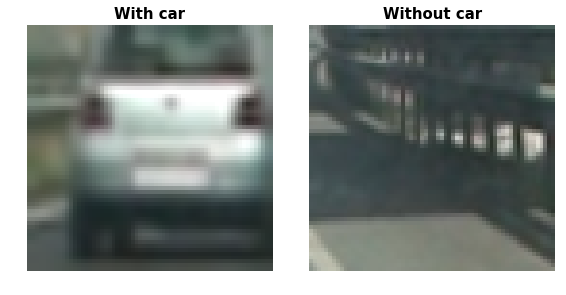

In [8]:
# Display a sample image for vehicle and non-vehicle image
imgs = (X_train_veh[100], X_train_non_veh[100])
cmaps = (None,None)
headings = ("With car","Without car")
save_path = "output_images/01_classifier_images"

# Plot and save comparison of example images
plot_and_save_n_images(imgs, cmaps, headings, save = True, save_path = save_path, 
                       images_per_column = 1, images_per_line = 2, figw = 8, figh = 4)

In [9]:
# Concatenate data for vehicle and non-vehicle objects to create training and testing data
X_train = np.concatenate((X_train_veh,X_train_non_veh))
X_test = np.concatenate((X_test_veh,X_test_non_veh))
y_train = np.concatenate((y_train_veh, y_train_non_veh))
y_test = np.concatenate((y_test_veh, y_test_non_veh))

# Shuffle training and testing data
X_train,y_train = shuffle(X_train,y_train)
X_test,y_test = shuffle(X_test,y_test)

## 1.2 Extract image features

In [10]:
def extract_features(imgs, color_space, orient, pix_per_cell, cell_per_block, hog_channel, classifier_shape):
    """
    Extract hog and color features from an array of images
    
    Input:
    imgs (np.array): Array of images
    color_space (str): Selected color channel for feature detection
    orient (int): Number of HOG orientations
    pix_per_cell (int): HOG pixels per cell
    cell_per_block (int): HOG cells per block
    hog_channel: Can be 0, 1, 2, or "ALL"
    classifier_shape (tuple): Defines the image shape used for the classifier
    """
    
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs:
        
        # Resize image
        img = (cv2.resize(img,dsize=classifier_shape)/255).astype(np.float32)
        
        # Apply color conversion if other than 'RGB'
        if color_space == 'HSV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)/255
        elif color_space == 'LUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)/255
        elif color_space == 'HLS':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)/255
        elif color_space == 'YUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)/255
        elif color_space == 'YCrCb':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)/255
            
        # Extract color features
        #col_features =  (cv2.resize(np.copy(img),(20,20))/255).ravel()
        col_features = np.copy(img).ravel()
        
        
        # Extract hog features
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(img.shape[2]):
                hog_features.append(hog(img[:,:,channel],orientations=orient,
                                            pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                            cells_per_block=(cell_per_block, cell_per_block), 
                                            transform_sqrt=True, visualise=False, feature_vector=True))
            hog_features = np.ravel(hog_features)

        
        else:
            hog_features = hog(img[:,:,hog_channel], orientations=orient,
                                            pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                            cells_per_block=(cell_per_block, cell_per_block), 
                                            transform_sqrt=True, visualise=False, feature_vector=True)
        
        # Append hog and color features to feature list
        features.append(np.concatenate((hog_features,col_features)))
        
   
    
    # Return list of feature vectors
    return features

In [11]:
# Extract features for train images
t1 = time.time()
X_train_feat = extract_features(X_train, color_space, orient, pix_per_cell, cell_per_block, hog_channel,
                                classifier_shape)
t2 = time.time()
print("Seconds to extract training features:\t{:.2f}".format(t2-t1))

# Extract features for test images
t1 = time.time()
X_test_feat = extract_features(X_test, color_space, orient, pix_per_cell, cell_per_block, hog_channel,
                               classifier_shape)
t2 = time.time()
print("Seconds to extract test features:\t{:.2f}".format(t2-t1))

Seconds to extract training features:	11.77
Seconds to extract test features:	2.84


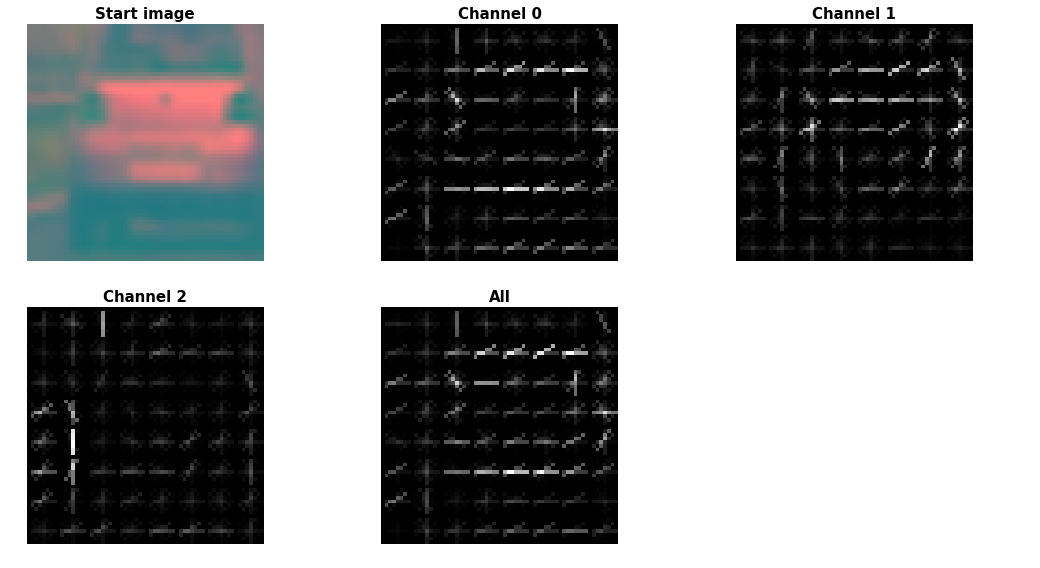

In [12]:
# Function to experiment with hog features
def visualize_hog(img, hog_channel):
    """
    Visualizes the hog_features based on the input image
    Input:
    img (np.array): Input image
    hog_channel: Indicates which hog_channels to be displayed (Can be 0, 1, 2, or "ALL")
    Output:
    imgs (list of np.arrays): List of visualized images
    cmaps (list of strings): Required cmaps for image display
    headings (list of strings): List of desired heading for each image
    """    

    vis = True
    feature_vec = True
            
    # Initialize lists to take up parameters for all images to be visualized (already contains initial image)
    img_tmp = np.copy(img)
    imgs = [img_tmp]
    cmaps = [None]
    headings = ["Start image"]    
    
    # Add parameters for 0-image channel to lists
    if hog_channel == 0 or hog_channel == "ALL":
        imgs.append(img_tmp[:,:,0])
        cmaps.append("gray")
        headings.append("Channel 0")
    # Add parameters for 1-image channel to lists
    if hog_channel == 1 or hog_channel == "ALL":
        imgs.append(img_tmp[:,:,1])
        cmaps.append("gray")
        headings.append("Channel 1")
    # Add parameters for 2-image channel to lists
    if hog_channel == 2 or hog_channel == "ALL":
        imgs.append(img_tmp[:,:,2])
        cmaps.append("gray")
        headings.append("Channel 2")
    # Add parameters for all-image channels (black and white image) to lists
    if hog_channel == "ALL":
        imgs.append(cv2.cvtColor(img_tmp, cv2.COLOR_RGB2GRAY))
        cmaps.append("gray")
        headings.append("All")

    # Get image visualizations for all images in list
    for i, img_obj in enumerate(imgs[1:]):
        _, imgs[i+1] = hog(img_obj, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        
    return imgs, cmaps, headings

# Define example image
input_img = X_train_veh[100]

# Convert image to YCrCb color space
input_img = cv2.cvtColor(input_img, cv2.COLOR_RGB2YCrCb)

# Call hog_visualization function (see above)
imgs, cmaps, headings = visualize_hog(input_img,"ALL")

# Plot and save comparison of all visualized images
save_path = "output_images/02_hog_features_YCrCb"
plot_and_save_n_images(imgs, cmaps, headings, save = True, save_path = save_path, 
                       images_per_column = 2, images_per_line = 3, figw = 15, figh = 8)

## 1.3 Scale training and testing data

In [13]:
# Fit a per-column scaler
features_scaler = StandardScaler().fit(np.concatenate((X_train_feat,X_test_feat)))
                                       
# Apply the scaler to train and test features
X_train_feat = features_scaler.transform(X_train_feat)
X_test_feat = features_scaler.transform(X_test_feat)  

## 1.4 Fit and test classifier (SVM)

In [14]:
# Define SVM classifier
svc = LinearSVC()

# Fit classifier
t1 = time.time()
svc.fit(X_train_feat, y_train)
t2 = time.time()
print("Seconds to train classifier:\t{:.2f}".format(t2-t1))

Seconds to train classifier:	4.59


In [15]:
# Evaluate classifier
accuracy = svc.score(X_test_feat, y_test)
print("Accuracy of current classifier:\t{:.4f}".format(accuracy))

Accuracy of current classifier:	0.9679


# 2 Sliding Window Search

## 2.0 Load test images

In [16]:
# Read in test images

# Get all test image pathes
test_img_names = sorted(glob.glob('test_images/*.jpg'))

# Load test images into np.array
test_imgs = np.array([mpimg.imread(name) for name in test_img_names])
    
print("Shape of test image array:\n{}".format(test_imgs.shape))

Shape of test image array:
(6, 720, 1280, 3)


## 2.1 Define windows

In [17]:
def generate_windows(y_start, y_stop, x_start, x_stop, win_per_row, win_per_col, window_size):
    """
    Determines window positions in an image for window search based on one window search
    parameter (input dictionary to fill function variables)
    
    Input:
    y_start (int): Pixel value on y-axis of an image on which to start window search
    y_stop (int): Pixel value on y-axis of an image on which to end window search
    x_start (int): Pixel value on x-axis of an image on which to start window search
    x_stop (int): Pixel value on x-axis of an image on which to end window search
    win_per_row (int): Number of windows in row
    win_per_col (int): Number of windows in column
    window_size (tuple): Window size in pixel -> (x-value, y-value)
        
    Output:
    window_positions (tuple): Window positions for one window search parameter marked by 2 corner points
                                per window in the format ((x_low,y_low),(x_high,y_high))
    """    
    
    # Determine pixel size of search area
    y_size = y_stop-y_start
    x_size = x_stop-x_start
    
    # Determine stride of windows based on desired number of images on each axis
    window_stride_y = (y_size - window_size[1]) // (win_per_col-1)
    window_stride_x = (x_size - window_size[0]) // (win_per_row-1)
    
    # Determine window positions
    window_positions = []    
    for row in range(win_per_col):
        y_low = y_start + row * window_stride_y
        y_high = y_low + window_size[1]
        for col in range(win_per_row):
            x_low = x_start + col * window_stride_x
            x_high = x_low + window_size[0]
            window_positions.append(((x_low,y_low),(x_high,y_high)))   
    
    return window_positions

In [18]:
def get_window_positions(window_search_param):
    """
    Determines all window positions in an image for window search based on single or multiple window search
    parameters
    
    Input:
    
    window_search_param (dict): Dictionary containing the following items:
        y_start (int): Pixel value on y-axis of an image on which to start window search
        y_stop (int): Pixel value on y-axis of an image on which to end window search
        x_start (int): Pixel value on x-axis of an image on which to start window search
        x_stop (int): Pixel value on x-axis of an image on which to end window search
        win_per_row (int): Number of windows in row
        win_per_col (int): Number of windows in column
        window_size (tuple): Window size in pixel -> (x-value, y-value)
        
    Output:
    window_positions (tuple): Window positions marked by 2 corner points per window in the format 
                                ((x_low,y_low),(x_high,y_high))
    """
    
    # Iterate through window search parameters calling 'generate_windows()' to extract window corner points
    window_positions = []
    for param in window_search_param:
        win_pos_tmp = generate_windows(**param)
        for i in (win_pos_tmp):
            window_positions.append(i)
        
    return window_positions

In [19]:
# Search area with normal sized window
window1 = {"y_start":390,"y_stop":570,"x_start":240,"x_stop":1040,
        "win_per_row":20,"win_per_col":3,"window_size":(135,90)}
# Search area with smaller sized windows
window2 = {"y_start":400,"y_stop":500,"x_start":0,"x_stop":1280,
        "win_per_row":30,"win_per_col":2,"window_size":(90,65)}
# Search area for very small sized windows for cars in the distance
window3 = {"y_start":400,"y_stop":450,"x_start":390,"x_stop":890,
        "win_per_row":15,"win_per_col":2,"window_size":(35,35)}
# Search area on the left
window4 = {"y_start":390,"y_stop":570,"x_start":0,"x_stop":350,
        "win_per_row":5,"win_per_col":5,"window_size":(180,110)}
# Search area on the right
window5 = {"y_start":390,"y_stop":570,"x_start":940,"x_stop":1280,
        "win_per_row":5,"win_per_col":5,"window_size":(180,110)}

# Search area left top
window6 = {"y_start":390,"y_stop":500,"x_start":230,"x_stop":430,
        "win_per_row":5,"win_per_col":5,"window_size":(100,70)}

# Search area right top
window7 = {"y_start":390,"y_stop":500,"x_start":850,"x_stop":1050,
        "win_per_row":5,"win_per_col":5,"window_size":(100,70)}

# Concatenate window parameters
window_search_param = [window1,window2,window3,window4,window5,window6,window7]
#,window2,window3,window4,window5

# Get window positions
window_positions = get_window_positions(window_search_param)

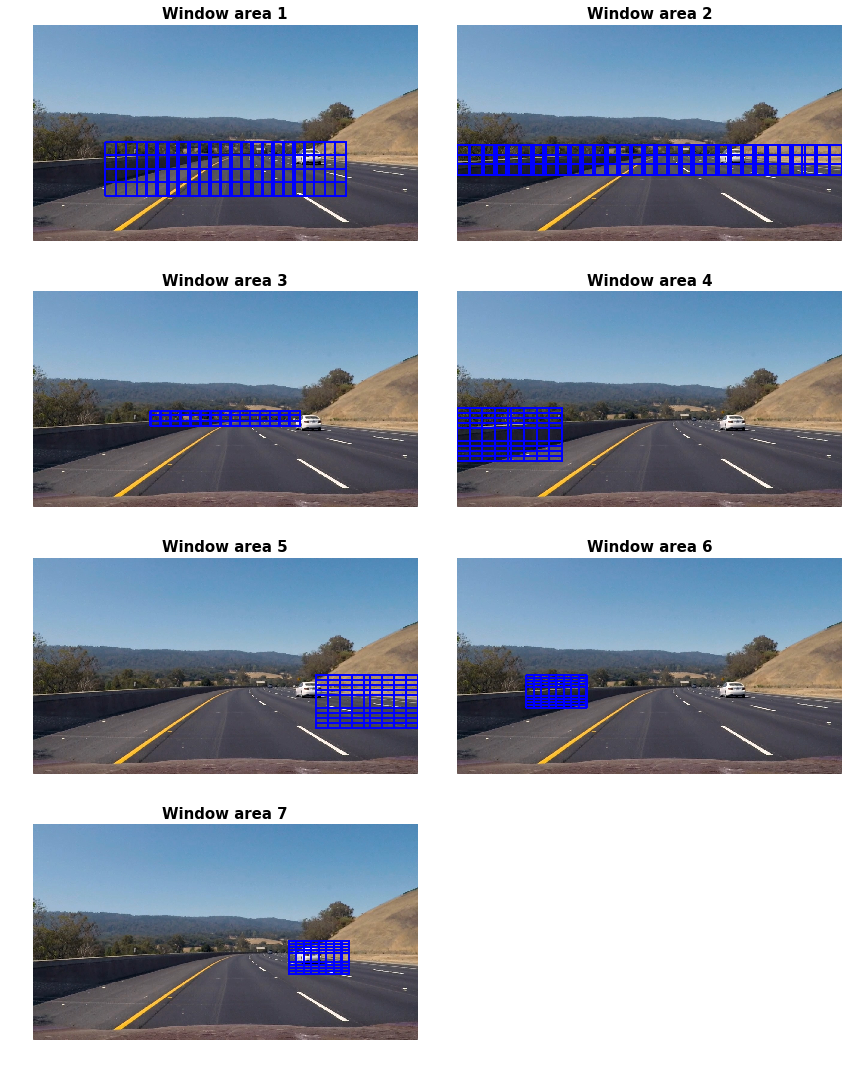

In [20]:
# Visualize image regions

# Define example image
example_img = test_imgs[2]
    

ex_window_areas = [draw_windows_on_image(np.copy(example_img), get_window_positions([window_region,])) for window_region in window_search_param]
cmaps = [None for i in range(len(ex_window_areas))]
headings = ["Window area {}".format(str(i+1)) for i in range(len(ex_window_areas))]
save_path = "output_images/03_window_areas.png"


plot_and_save_n_images(ex_window_areas, cmaps, headings, save = True, save_path = save_path, 
                           images_per_column = 4, images_per_line = 2,  figw = 12, figh = 15)


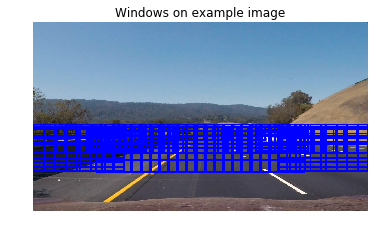

In [21]:
# Visualize windows on an example image
img_window_ex = draw_windows_on_image(example_img, window_positions)
plot_and_save_image(img_window_ex, cmap_img = None, heading = "Windows on example image", 
                     save = True, save_path = "output_images/04_image_windows")

## 2.2 Get features and predictions for windows

In [22]:
def assemble_and_resize_windows(img, window_positions, classifier_shape = classifier_shape):
    """
    Create a pipeline of all windows to be analyzed in an image
    
    Input:
    img (np.array): Image to be analyzed
    window_positions (tuple): Window positions marked by 2 corner points per window in the format 
                                ((x_low,y_low),(x_high,y_high))
    classifier_shape (tuple): Defines the image shape used for the classifier
    
    Ouptput:
    window_imgs (np.array): Array including all windows to be analyzed as images
    """

    window_imgs = []
        
    # For all window positions
    for position in window_positions:
        # Cut window region from image
        tmp_img = img[position[0][1]:position[1][1],position[0][0]:position[1][0],:]
        # Resize image to classifier size
        tmp_img = cv2.resize(tmp_img,dsize=classifier_shape)/255
        # Append to list of window images
        window_imgs.append(tmp_img)
        
        
    return np.array(window_imgs)

In [23]:
def make_predictions(imgs,svc, orient, pix_per_cell, cell_per_block, hog_channel, classifier_shape, 
                     features_scaler):
    """
    Make predictions on a series of images
    
    Input:
    imgs(list): Images to make predictions for (typically an array of the windows to be analyzed)
    svc: Fitted classifier
    orient (int): Number of HOG orientations
    pix_per_cell (int): HOG pixels per cell
    cell_per_block (int): HOG cells per block
    hog_channel: Can be 0, 1, 2, or "ALL"
    classifier_shape (tuple): Defines the image shape used for the classifier
    features_scaler: Per-column scaler generated based on classifier input data
    
    Output:
    prediction (list): List of prediction values for each input image
    """
    # Extract features from all input images (windows)
    feature_vector = extract_features(imgs, color_space, orient, pix_per_cell, cell_per_block, hog_channel, 
                                      classifier_shape)
    # Apply the scaler to feature images
    feature_vector_scaled = features_scaler.transform(feature_vector)
    
    # Make prediction on feature images
    prediction = svc.predict(feature_vector_scaled)
    
    return prediction

In [24]:
# Get features and predictions for example images

# Create a copy of test images to draw on
test_imgs_draw = np.copy(test_imgs)

test_imgs_windows = []
test_imgs_predictions = []
test_imgs_predicted_windows = []

# For all test images
for i,img in enumerate(test_imgs_draw):

    # Create a pipeline of all windows to be analyzed in the image
    window_imgs = assemble_and_resize_windows(img, window_positions=window_positions)

    #Make predictions on the image pipeline
    prediction = make_predictions(window_imgs,svc, orient, pix_per_cell, cell_per_block, hog_channel, 
                                  classifier_shape,features_scaler)
    
    # Store parameters
    test_imgs_windows.append(window_imgs)
    test_imgs_predictions.append(prediction)
    test_imgs_predicted_windows.append(draw_windows_on_image(img, window_positions, prediction = prediction))

/home/wolfgang/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()


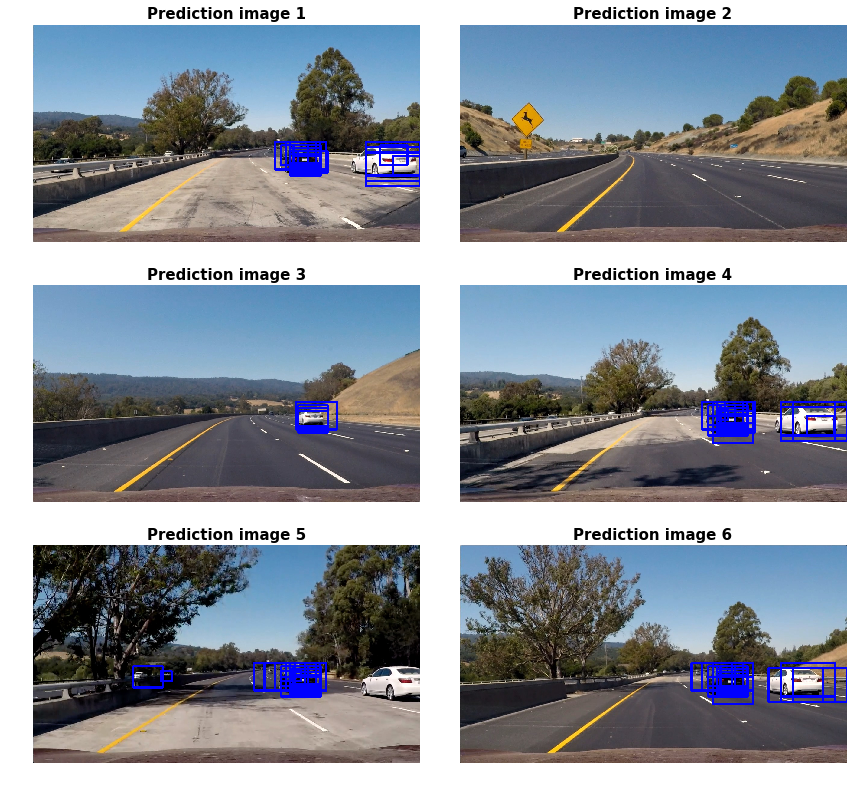

In [25]:
# Plot and save visualizations of predicted windows for all example images

test_imgs_predicted_windows = np.array(test_imgs_predicted_windows)
cmaps = [None for i in range(len(test_imgs_predicted_windows))]
headings = ["Prediction image {}".format(str(i+1)) for i in range(len(test_imgs_predicted_windows))]
save_path = "output_images/05_predictions.png"    
    
plot_and_save_n_images(test_imgs_predicted_windows, cmaps, headings, save = True, 
                       save_path = save_path, images_per_column = 3, images_per_line = 2, 
                       figw = 12, figh = 11)

## 2.3 Get image heatmap and return window

In [26]:
def get_activated_windows(prediction,window_positions):
    """
    Extracts activated windows
    
    Input:
    prediction (list): List of prediction values for each window
    window_positions (tuple): Window positions marked by 2 corner points per window in the format 
                                ((x_low,y_low),(x_high,y_high))
    
    Output:
    windows_active: All positions of active window frames marked by 2 corner points per window in the format 
                                ((x_low,y_low),(x_high,y_high))
    """
    
    windows_active = []
    
    for pre,pos in zip(prediction,window_positions):
        if pre:
            windows_active.append(pos)
        
    windows_active = np.array(windows_active)
    
    
    return windows_active

In [27]:
def add_heat(heatmap, windows_active):
    """
    Recognize activated windows in heatmap
    
    Input:
    heatmap (np.array): Heatmap to add activated windows to
    windows_active: All positions of active window frames marked by 2 corner points per window in the format 
                                ((x_low,y_low),(x_high,y_high))
    
    Output:
    heatmap (np.array): Input heatmap incremented by activated windows
    
    """
    # Iterate through list of active windows
    for window in windows_active:
        # Increment pixel value of heatmap by 1 for each activated window on it
        heatmap[window[0][1]:window[1][1],window[0][0]:window[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [28]:
def apply_threshold(heatmap, threshold):
    """
    Apply threshold to heatmap (this function currently is only used in video tracking)
    
    Input:
    heatmap (np.array): Heatmap subject to threshold
    threshold (int): Threshold value below which heatmap is deactivated
    """
    
    # Zero out heatmap pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    return heatmap

In [29]:
# Get heatmaps for example images

heatmaps = []

# For all example images
for i in range(len(test_imgs_predictions)):
    # Get activated windows
    windows_activated = get_activated_windows(test_imgs_predictions[i], window_positions)
    # Create empty heatmap
    heat = np.zeros((input_image_shape_y,input_image_shape_x))
    # Recognize activated windows in heatmap
    heatmap = add_heat(heat, windows_activated)
    # Append heatmap to list of heatmaps
    heatmaps.append(heatmap)
heatmaps = np.array(heatmaps)

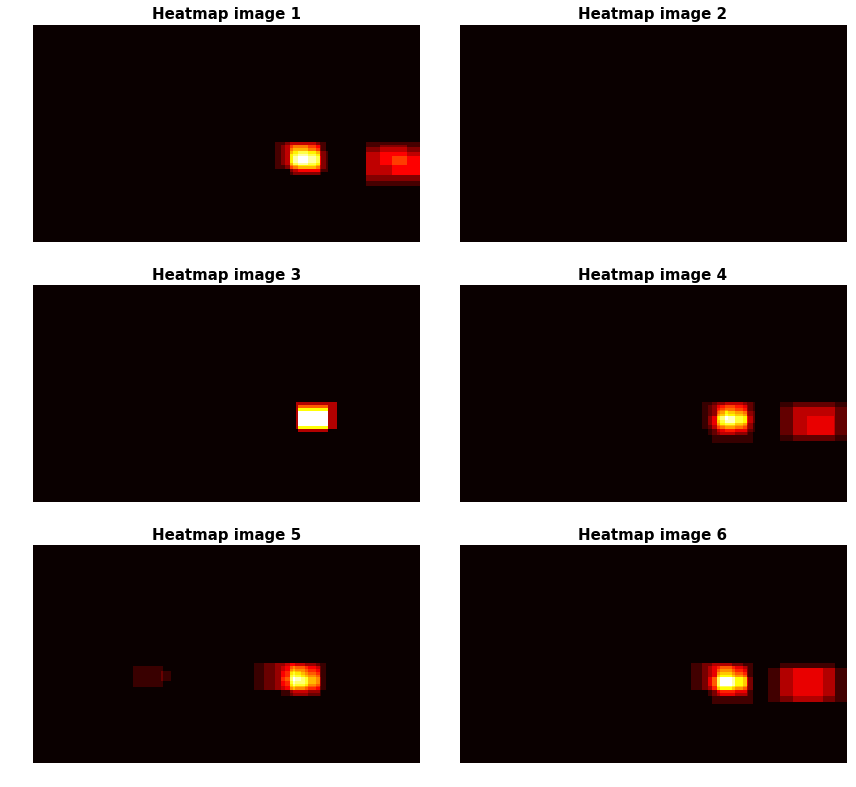

In [30]:
# Plot and save visualizations of heatmaps for all example images

# Prepare heatmaps for visualization
heatmaps_vis = np.array([np.clip(heat, 0, 255) for heat in heatmaps])

# Create visualization parameters
cmaps = ["hot" for i in range(len(heatmaps))]
headings = ["Heatmap image {}".format(str(i+1)) for i in range(len(heatmaps))]
save_path = "output_images/06_heatmaps.png"

# Plot and save heatmaps
plot_and_save_n_images(heatmaps_vis, cmaps, headings, save = True, save_path = save_path,
                       images_per_column = 3, images_per_line = 2, figw = 12, figh = 11)

## 2.4 Create labeled windows

In [31]:
def get_label(heatmap):
    """
    Label heatmap features
    
    Input:
    heatmap (np.array): Heatmap to be labeled
    
    Output:
    heatmap_labels: An integer ndarray where each unique feature in input has a 
                    unique label in the returned array.
    """
    
    return np.array(label(heatmap))

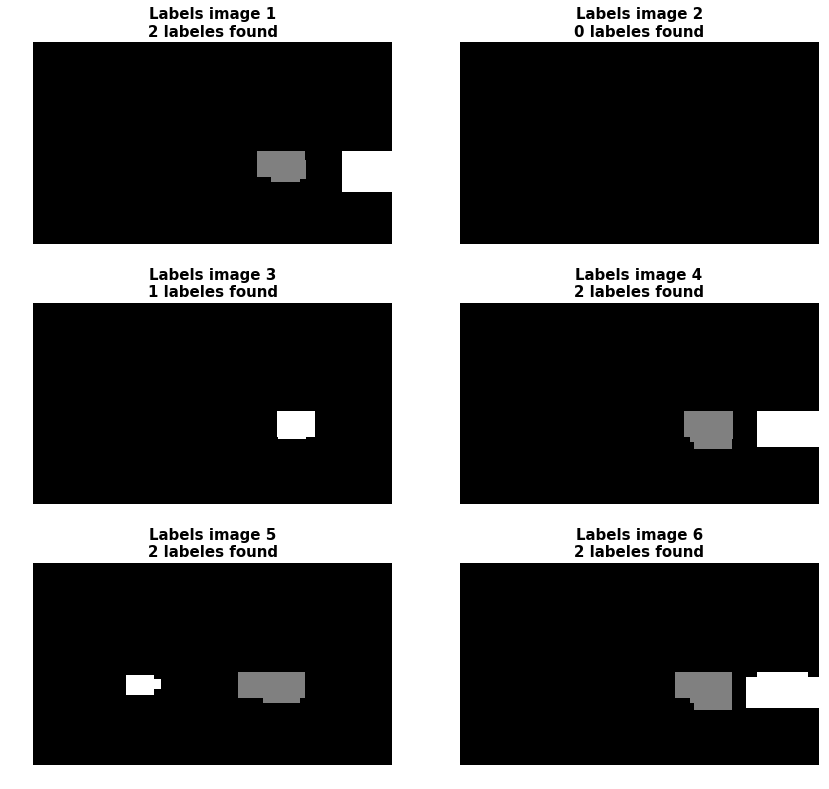

In [32]:
# Plot and save visualizations of labels for all example images

# Get labels for example images
example_imgs_labels = [get_label(heatmap) for heatmap in heatmaps]

# Create visualization parameters
example_imgs = np.array([example_imgs_labels[i][0] for i in range(len(example_imgs_labels))])
cmaps = ["gray" for i in range(len(example_imgs_labels))]
headings = ["Labels image {}\n{} labeles found".format(str(i+1), str(example_imgs_labels[i][1])) for i in range(len(example_imgs_labels))] 
save_path = "output_images/07_labels.png"

# Plot and save label images
plot_and_save_n_images(example_imgs, cmaps, headings, save = True, save_path = save_path,
                       images_per_column = 3, images_per_line = 2, figw = 12, figh = 11)

In [33]:
def draw_labeled_windows(img, labels):
    """
    Draw boxes around identified labels on image
    """
    
    try:
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    except:
        pass
    # Return the image
    return img

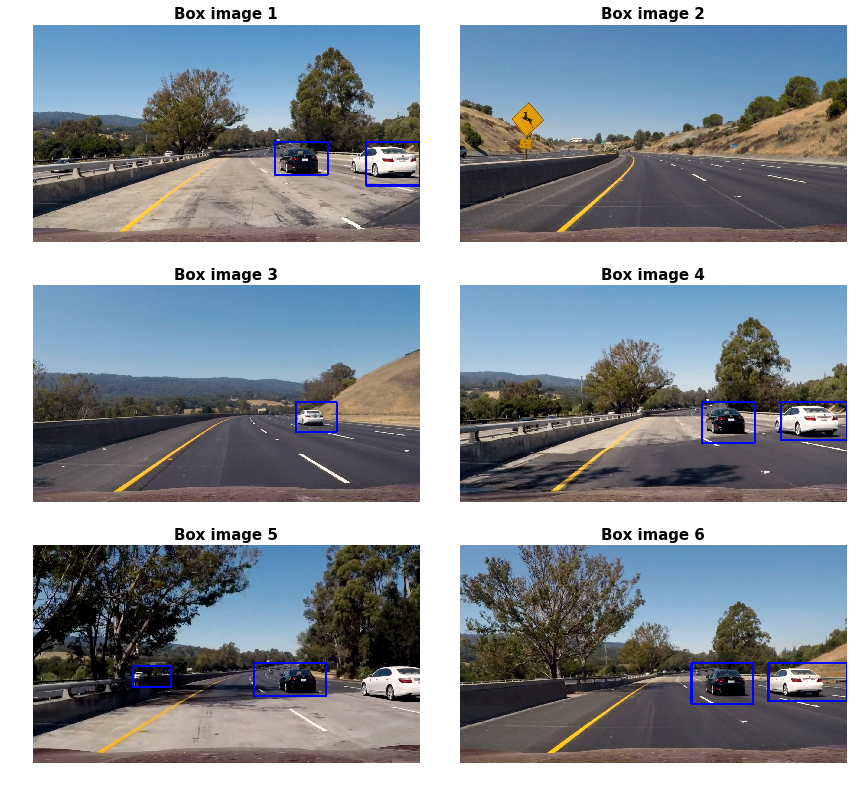

In [34]:
# Create images with boxes
example_imgs = [draw_labeled_windows(np.copy(test_imgs[i]),example_imgs_labels[i]) for i in range(len(example_imgs))]

# Create visualization parameters
cmaps = [None for i in range(len(example_imgs))]
headings = ["Box image {}".format(str(i+1)) for i in range(len(example_imgs))] 
save_path = "output_images/08_boxes.png"

# Plot and save label images
plot_and_save_n_images(example_imgs, cmaps, headings, save = True, save_path = save_path,
                       images_per_column = 3, images_per_line = 2, figw = 12, figh = 11)

# 3 Video Implementation

## 3.1 Define class to store previous image values

In [35]:
class Windows():
    """
    Class to hold detections over multiple images in a video stream
    """
    def __init__(self, backlog):
        """
        Input:
        backlog (int): Number of previous images for which data is stored
        """        
        
        # what is the backlog stored in the class
        self.backlog = backlog
        
        # values for previous images
        self.windows = []

    
    
    def update_value_collection(self, update_item, update_value):
        """
        Input:
        update item (list): needs to be a stored list to be updated with a new value
        udate_value: needs to be the value with which the list should be updated
        Output:
        update_item (list): updated list
        """
        udate_item = update_item.append(update_value)
        if len(update_item) > self.backlog:
            update_item = update_item[1:]
        return update_item

    
    def update(self,identified_windows):
        """
        Input:
        identified_windows (list): List of identified windows in the format ((x1,y1),(x2,y2))              
        """
        
        self.windows = self.update_value_collection(self.windows, identified_windows)

## 3.2 Define function to apply processing pipeline on image

In [36]:
def process_video_images(img,window_positions, input_image_shape_x,input_image_shape_y, classifier_shape, 
                         svc, orient, pix_per_cell, cell_per_block, hog_channel, features_scaler, 
                         heat_threshold_multiple):
    """
    Apply full pipeline defined in section 2 on the images of a video stream
    
    Input:
    img (np.array): Single image from video stream
    window_positions (tuple): Window positions marked by 2 corner points per window in the format 
                                ((x_low,y_low),(x_high,y_high))
    input_image_shape_x,input_image_shape_y: Pixel size of input images
    classifier_shape (tuple): Defines the image shape used for the classifier
    svc: Fitted classifier
    orient (int): Number of HOG orientations
    pix_per_cell (int): HOG pixels per cell
    cell_per_block (int): HOG cells per block
    hog_channel: Can be 0, 1, 2, or "ALL"    
    features_scaler: Per-column scaler generated based on classifier input data
    heat_threshold_multiple (int): Required pixel value in average heatmap of image backlog
                                    to maintain activation
    
    Output:
    result: Image with boxes for car detections plotted on it
    """
    
    # Create a pipeline of all windows to be analyzed in the image
    window_imgs = assemble_and_resize_windows(img,window_positions,classifier_shape)
    
    # Make prediction
    prediction = make_predictions(window_imgs,svc, orient, pix_per_cell, cell_per_block, hog_channel, 
                                  classifier_shape,features_scaler)
    # If at least one window is activated
    if np.sum(prediction) > 0:
        # Get activated windows
        windows_active = get_activated_windows(prediction, window_positions)
        # Add activated windows to window tracker and remove activated windows from oldest detection
        window_tracker.update(windows_active)
       
    # Generate empty heatmap
    heat = np.zeros((input_image_shape_y,input_image_shape_x))    
   
    # Concatenate previous and current detections and create heatmap
    windows_active_last_imgs = np.concatenate(window_tracker.windows)
    heatmap = add_heat(heat, windows_active_last_imgs)
    
    # Apply threshold on heatmap
    heatmap_thr = apply_threshold(heatmap, heat_threshold_multiple)
    
    # Get labels from heatmap
    labels = get_label(heatmap_thr)
    
    # Draw boxes on image
    result = draw_labeled_windows(img, labels)
    
    return result

## 3.3 Process video

In [37]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [38]:
window_tracker = Windows(backlog = backlog)

# Define a function which only returns the image output of the function "process_video_images()"
def process_image_video(img):

    result = process_video_images(img,window_positions, input_image_shape_x,input_image_shape_y, 
                                  classifier_shape, svc, orient, pix_per_cell, cell_per_block, hog_channel, 
                                  features_scaler, heat_threshold_multiple)

    return result

In [39]:
# Process the video
video_output = 'project_video_annotated.mp4'
video_input = VideoFileClip("project_video.mp4")
white_clip = video_input.fl_image(process_image_video) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_annotated.mp4
[MoviePy] Writing video project_video_annotated.mp4


100%|█████████▉| 1260/1261 [06:20<00:00,  3.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_annotated.mp4 

CPU times: user 6min 34s, sys: 4min 38s, total: 11min 12s
Wall time: 6min 22s
